In [1]:
"""
CryptoWhiz - Advanced Autonomous Cryptocurrency Trading System
================================================================
A complete AI-powered trading system using free data sources and libraries.

Installation Requirements:
pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow torch transformers requests arch

Data Sources:
- Price data: CoinGecko API (free, no authentication needed) with Yahoo Finance fallback
- Sentiment data: FinBERT for text analysis
- All models are open-source and free to use

Note: CoinGecko free tier allows ~50 calls/minute. The system includes automatic rate limiting.
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
import sys

# Suppress all warnings and widget errors
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'  # Suppress transformers warnings

# Disable tqdm progress bars that cause widget errors
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Volatility Modeling
from arch import arch_model

# ============================================================================
# 1. DATA ACQUISITION MODULE
# ============================================================================

import time
import requests

class DataAcquisition:
    """Fetches cryptocurrency price data from multiple sources"""
    
    def __init__(self):
        self.top_10_cryptos = [
            'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD',
            'DOGE-USD', 'SOL-USD', 'TRX-USD', 'DOT-USD', 'USDT-USD'
        ]
        # CoinGecko ID mapping
        self.coingecko_map = {
            'BTC-USD': 'bitcoin',
            'ETH-USD': 'ethereum',
            'BNB-USD': 'binancecoin',
            'XRP-USD': 'ripple',
            'ADA-USD': 'cardano',
            'DOGE-USD': 'dogecoin',
            'SOL-USD': 'solana',
            'TRX-USD': 'tron',
            'DOT-USD': 'polkadot',
            'USDT-USD': 'Tether'
        }
    
    def fetch_from_coingecko(self, symbol, days=180):
        """Fetch data from CoinGecko API (free, no auth needed)"""
        try:
            coin_id = self.coingecko_map.get(symbol)
            if not coin_id:
                return None
            
            url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
            params = {
                'vs_currency': 'usd',
                'days': days,
                'interval': 'daily'
            }
            
            response = requests.get(url, params=params, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                
                # Convert to DataFrame
                prices = data['prices']
                volumes = data['total_volumes']
                
                df = pd.DataFrame(prices, columns=['timestamp', 'Close'])
                df['Volume'] = [v[1] for v in volumes]
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                df.set_index('timestamp', inplace=True)
                
                # Add OHLC (approximate from close prices)
                df['Open'] = df['Close'].shift(1).fillna(df['Close'])
                df['High'] = df['Close'] * 1.02  # Approximate
                df['Low'] = df['Close'] * 0.98   # Approximate
                df['Symbol'] = symbol
                
                return df
            else:
                return None
                
        except Exception as e:
            print(f"  ⚠ CoinGecko error for {symbol}: {e}")
            return None
    
    def fetch_price_data(self, symbol, period='1y', interval='1d'):
        """Fetch historical price data with fallback sources"""
        # Try Yahoo Finance first
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(period=period, interval=interval)
            if not df.empty:
                df['Symbol'] = symbol
                return df
        except Exception as e:
            pass  # Silent fail, try alternative
        
        # Fallback to CoinGecko
        days_map = {'1mo': 30, '3mo': 90, '6mo': 180, '1y': 365}
        days = days_map.get(period, 180)
        
        return self.fetch_from_coingecko(symbol, days=days)
    
    def fetch_all_cryptos(self, period='6mo'):
        """Fetch data for all top 10 cryptocurrencies with rate limiting"""
        data = {}
        print("Fetching cryptocurrency data...")
        print("(Using CoinGecko API )\n")
        
        for i, crypto in enumerate(self.top_10_cryptos, 1):
            print(f"[{i}/{len(self.top_10_cryptos)}] Downloading {crypto}...", end=' ')
            
            df = self.fetch_price_data(crypto, period=period)
            
            if df is not None and not df.empty:
                data[crypto] = df
                print(f"✓ ({len(df)} data points)")
            else:
                print("✗ Failed")
            
            # Rate limiting: wait between requests
            if i < len(self.top_10_cryptos):
                time.sleep(1.5)  # 1.5 second delay to respect API limits
        
        print(f"\n✓ Successfully fetched {len(data)}/{len(self.top_10_cryptos)} cryptocurrencies\n")
        return data
    
    def get_sentiment_mock(self, symbol):
        """
        Mock sentiment data (0-1 scale)
        In production, integrate with CryptoPanic API or NewsAPI
        """
        # Simulate sentiment based on recent price action
        return np.random.uniform(0.3, 0.7)

# ============================================================================
# 2. TECHNICAL ANALYSIS AGENT (LSTM)
# ============================================================================

class TechnicalAnalysisAgent:
    """LSTM-based price prediction and technical analysis"""
    
    def __init__(self, lookback=60):
        self.lookback = lookback
        self.scaler = MinMaxScaler()
        self.model = None
    
    def prepare_data(self, df):
        """Prepare data for LSTM training"""
        # Use Close price
        data = df['Close'].values.reshape(-1, 1)
        scaled_data = self.scaler.fit_transform(data)
        
        X, y = [], []
        for i in range(self.lookback, len(scaled_data)):
            X.append(scaled_data[i-self.lookback:i, 0])
            y.append(scaled_data[i, 0])
        
        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        
        return X, y, scaled_data
    
    def build_model(self):
        """Build LSTM model"""
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(self.lookback, 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    def train(self, df, epochs=10, batch_size=32):
        """Train LSTM model"""
        X, y, _ = self.prepare_data(df)
        
        # Split data
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        
        self.model = self.build_model()
        
        print(f"Training LSTM model with {len(X_train)} samples...")
        self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            verbose=0
        )
        
        return self.model
    
    def predict_next(self, df):
        """Predict next price movement"""
        if self.model is None:
            return None
        
        _, _, scaled_data = self.prepare_data(df)
        last_sequence = scaled_data[-self.lookback:].reshape(1, self.lookback, 1)
        
        prediction = self.model.predict(last_sequence, verbose=0)
        prediction = self.scaler.inverse_transform(prediction)
        
        current_price = df['Close'].iloc[-1]
        predicted_price = prediction[0][0]
        
        return {
            'current': current_price,
            'predicted': predicted_price,
            'change_pct': ((predicted_price - current_price) / current_price) * 100,
            'signal': 'BUY' if predicted_price > current_price else 'SELL'
        }
    
    def calculate_indicators(self, df):
        """Calculate technical indicators"""
        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # Moving Averages
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        
        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
        return df

# ============================================================================
# 3. SENTIMENT ANALYSIS AGENT (FinBERT)
# ============================================================================

class SentimentAnalysisAgent:
    """FinBERT-based sentiment analysis"""
    
    def __init__(self):
        print("Loading FinBERT model (this may take a moment)...")
        try:
            # Disable progress bars for model loading
            self.tokenizer = AutoTokenizer.from_pretrained(
                "ProsusAI/finbert",
                use_fast=True
            )
            self.model = AutoModelForSequenceClassification.from_pretrained(
                "ProsusAI/finbert"
            )
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model.to(self.device)
            self.model.eval()  # Set to evaluation mode
            print("✓ FinBERT model loaded successfully!")
        except Exception as e:
            print(f"⚠ Error loading FinBERT: {e}")
            print("  Using fallback sentiment analysis...")
            self.model = None
            self.tokenizer = None
    
    def analyze_text(self, text):
        """Analyze sentiment of text"""
        # Fallback if model failed to load
        if self.model is None or self.tokenizer is None:
            # Simple rule-based sentiment as fallback
            positive_words = ['bullish', 'growth', 'surge', 'rally', 'gain', 'profit', 'strong']
            negative_words = ['bearish', 'decline', 'crash', 'loss', 'weak', 'concern', 'risk']
            
            text_lower = text.lower()
            pos_count = sum(1 for word in positive_words if word in text_lower)
            neg_count = sum(1 for word in negative_words if word in text_lower)
            
            if pos_count > neg_count:
                return {'negative': 0.2, 'neutral': 0.3, 'positive': 0.5, 'compound': 0.3}
            elif neg_count > pos_count:
                return {'negative': 0.5, 'neutral': 0.3, 'positive': 0.2, 'compound': -0.3}
            else:
                return {'negative': 0.3, 'neutral': 0.4, 'positive': 0.3, 'compound': 0.0}
        
        inputs = self.tokenizer(text, return_tensors="pt", 
                               truncation=True, max_length=512,
                               padding=True).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment_score = probabilities[0].cpu().numpy()
        
        # FinBERT outputs: [negative, neutral, positive]
        sentiment = {
            'negative': float(sentiment_score[0]),
            'neutral': float(sentiment_score[1]),
            'positive': float(sentiment_score[2]),
            'compound': float(sentiment_score[2] - sentiment_score[0])  # -1 to 1
        }
        
        return sentiment
    
    def get_market_sentiment(self, symbol, news_list=None):
        """
        Get overall market sentiment for a cryptocurrency
        In production, fetch real news using NewsAPI or CryptoPanic
        """
        if news_list is None:
            # Mock news headlines
            news_list = [
                f"{symbol} shows strong momentum with institutional buying",
                f"Market analysts bullish on {symbol} future prospects",
                f"{symbol} faces regulatory concerns in key markets"
            ]
        
        sentiments = []
        for news in news_list:
            sent = self.analyze_text(news)
            sentiments.append(sent['compound'])
        
        avg_sentiment = np.mean(sentiments) if sentiments else 0
        
        return {
            'sentiment_score': avg_sentiment,
            'signal': 'POSITIVE' if avg_sentiment > 0.1 else 'NEGATIVE' if avg_sentiment < -0.1 else 'NEUTRAL',
            'confidence': abs(avg_sentiment)
        }

# ============================================================================
# 4. RISK MANAGEMENT AGENT (GARCH)
# ============================================================================

class RiskManagementAgent:
    """GARCH-based volatility modeling for risk management"""
    
    def __init__(self, max_position_size=0.2):
        self.max_position_size = max_position_size
        self.var_threshold = 0.05  # 5% Value at Risk threshold
    
    def calculate_returns(self, df):
        """Calculate log returns"""
        returns = np.log(df['Close'] / df['Close'].shift(1))
        return returns.dropna() * 100  # Convert to percentage
    
    def fit_garch(self, returns):
        """Fit GARCH(1,1) model"""
        try:
            model = arch_model(returns, vol='Garch', p=1, q=1)
            fitted = model.fit(disp='off')
            return fitted
        except:
            return None
    
    def calculate_var(self, returns, confidence=0.95):
        """Calculate Value at Risk"""
        return np.percentile(returns, (1 - confidence) * 100)
    
    def assess_risk(self, df):
        """Comprehensive risk assessment"""
        returns = self.calculate_returns(df)
        
        if len(returns) < 50:
            return None
        
        # Fit GARCH model
        garch_fit = self.fit_garch(returns)
        
        # Calculate volatility
        volatility = returns.std()
        
        # Calculate VaR
        var_95 = self.calculate_var(returns, 0.95)
        
        # Forecast volatility
        forecast_vol = volatility
        if garch_fit is not None:
            forecast = garch_fit.forecast(horizon=1)
            forecast_vol = np.sqrt(forecast.variance.values[-1, :][0])
        
        # Risk assessment
        risk_level = 'LOW'
        if forecast_vol > 5:
            risk_level = 'HIGH'
        elif forecast_vol > 3:
            risk_level = 'MEDIUM'
        
        # Position sizing
        position_size = self.max_position_size * (1 - min(forecast_vol / 10, 0.8))
        
        return {
            'volatility': volatility,
            'forecast_volatility': forecast_vol,
            'var_95': var_95,
            'risk_level': risk_level,
            'recommended_position': position_size,
            'sharpe_ratio': returns.mean() / volatility if volatility > 0 else 0
        }

# ============================================================================
# 5. MASTER AGENT (Deep Reinforcement Learning)
# ============================================================================

class MasterTradingAgent:
    """DRL-based master decision maker"""
    
    def __init__(self, state_size=10, action_size=3):
        self.state_size = state_size
        self.action_size = action_size  # BUY, SELL, HOLD
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()
    
    def _build_model(self):
        """Build DQN model"""
        model = Sequential([
            Dense(64, input_dim=self.state_size, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer='adam')
        return model
    
    def make_decision(self, ta_signal, sentiment_signal, risk_assessment):
        """
        Integrate all signals to make final trading decision
        
        Returns: 0 (SELL), 1 (HOLD), 2 (BUY)
        """
        # Create state vector
        state = np.array([
            1 if ta_signal['signal'] == 'BUY' else 0,
            ta_signal['change_pct'],
            sentiment_signal['sentiment_score'],
            risk_assessment['volatility'],
            risk_assessment['forecast_volatility'],
            risk_assessment['var_95'],
            risk_assessment['sharpe_ratio'],
            1 if risk_assessment['risk_level'] == 'HIGH' else 0,
            risk_assessment['recommended_position'],
            sentiment_signal['confidence']
        ]).reshape(1, -1)
        
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            action = np.random.randint(self.action_size)
        else:
            q_values = self.model.predict(state, verbose=0)
            action = np.argmax(q_values[0])
        
        # Apply risk override
        if risk_assessment['risk_level'] == 'HIGH':
            action = min(action, 1)  # Only HOLD or SELL in high risk
        
        action_map = {0: 'SELL', 1: 'HOLD', 2: 'BUY'}
        
        return {
            'action': action_map[action],
            'confidence': np.max(self.model.predict(state, verbose=0)),
            'position_size': risk_assessment['recommended_position'],
            'reasoning': self._explain_decision(ta_signal, sentiment_signal, risk_assessment, action_map[action])
        }
    
    def _explain_decision(self, ta_signal, sentiment_signal, risk_assessment, action):
        """Generate explanation for the decision"""
        reasons = []
        
        if action == 'BUY':
            reasons.append(f"Technical analysis predicts {ta_signal['change_pct']:.2f}% price increase")
            if sentiment_signal['sentiment_score'] > 0:
                reasons.append(f"Market sentiment is {sentiment_signal['signal']}")
        elif action == 'SELL':
            reasons.append("Risk management indicates prudent exit")
            if risk_assessment['risk_level'] == 'HIGH':
                reasons.append(f"High volatility detected ({risk_assessment['forecast_volatility']:.2f}%)")
        else:
            reasons.append("Mixed signals suggest holding current position")
        
        return " | ".join(reasons)

# ============================================================================
# 6. MAIN CRYPTOWHIZ SYSTEM
# ============================================================================

class CryptoWhiz:
    """Main trading system orchestrator"""
    
    def __init__(self):
        print("\n" + "="*60)
        print("🚀 INITIALIZING CRYPTOWHIZ TRADING SYSTEM")
        print("="*60)
        
        print("\n[1/5] Setting up data acquisition module...")
        self.data_module = DataAcquisition()
        print("      ✓ Complete")
        
        print("[2/5] Initializing technical analysis agent (LSTM)...")
        self.ta_agent = TechnicalAnalysisAgent()
        print("      ✓ Complete")
        
        print("[3/5] Loading sentiment analysis agent (FinBERT)...")
        self.sentiment_agent = SentimentAnalysisAgent()
        
        print("[4/5] Configuring risk management agent (GARCH)...")
        self.risk_agent = RiskManagementAgent()
        print("      ✓ Complete")
        
        print("[5/5] Deploying master trading agent (Deep RL)...")
        self.master_agent = MasterTradingAgent()
        print("      ✓ Complete")
        
        self.portfolio = {}
        self.trade_history = []
        
        print("\n" + "="*60)
        print("✅ SYSTEM READY!")
        print("="*60)
    
    def analyze_crypto(self, symbol, df):
        """Comprehensive analysis of a cryptocurrency"""
        print(f"\n{'='*60}")
        print(f"Analyzing {symbol}")
        print('='*60)
        
        # Technical Analysis
        print("Running Technical Analysis...")
        df = self.ta_agent.calculate_indicators(df)
        self.ta_agent.train(df, epochs=5)
        ta_signal = self.ta_agent.predict_next(df)
        
        # Sentiment Analysis
        print("Analyzing Market Sentiment...")
        sentiment_signal = self.sentiment_agent.get_market_sentiment(symbol)
        
        # Risk Assessment
        print("Assessing Risk...")
        risk_assessment = self.risk_agent.assess_risk(df)
        
        # Master Decision
        print("Making Trading Decision...")
        decision = self.master_agent.make_decision(ta_signal, sentiment_signal, risk_assessment)
        
        # Display Results
        self._display_analysis(symbol, ta_signal, sentiment_signal, risk_assessment, decision)
        
        return {
            'symbol': symbol,
            'ta_signal': ta_signal,
            'sentiment': sentiment_signal,
            'risk': risk_assessment,
            'decision': decision
        }
    
    def _display_analysis(self, symbol, ta, sentiment, risk, decision):
        """Display comprehensive analysis results"""
        print(f"\n📊 TECHNICAL ANALYSIS")
        print(f"  Current Price: ${ta['current']:.2f}")
        print(f"  Predicted Price: ${ta['predicted']:.2f}")
        print(f"  Expected Change: {ta['change_pct']:+.2f}%")
        print(f"  Signal: {ta['signal']}")
        
        print(f"\n💭 SENTIMENT ANALYSIS")
        print(f"  Sentiment Score: {sentiment['sentiment_score']:+.3f}")
        print(f"  Signal: {sentiment['signal']}")
        print(f"  Confidence: {sentiment['confidence']:.2%}")
        
        print(f"\n⚠️  RISK ASSESSMENT")
        print(f"  Current Volatility: {risk['volatility']:.2f}%")
        print(f"  Forecast Volatility: {risk['forecast_volatility']:.2f}%")
        print(f"  VaR (95%): {risk['var_95']:.2f}%")
        print(f"  Risk Level: {risk['risk_level']}")
        print(f"  Sharpe Ratio: {risk['sharpe_ratio']:.3f}")
        
        print(f"\n🎯 MASTER DECISION")
        print(f"  Action: {decision['action']}")
        print(f"  Confidence: {decision['confidence']:.2%}")
        print(f"  Position Size: {decision['position_size']:.1%}")
        print(f"  Reasoning: {decision['reasoning']}")
    
    def run_analysis(self, period='6mo'):
        """Run analysis on all top 10 cryptocurrencies"""
        print("\n" + "="*60)
        print("🚀 CRYPTOWHIZ AUTONOMOUS TRADING SYSTEM")
        print("="*60)
        
        # Fetch data
        crypto_data = self.data_module.fetch_all_cryptos(period=period)
        
        # Analyze each cryptocurrency
        results = {}
        for symbol, df in crypto_data.items():
            try:
                results[symbol] = self.analyze_crypto(symbol, df)
            except Exception as e:
                print(f"Error analyzing {symbol}: {e}")
        
        # Generate portfolio recommendations
        self._generate_portfolio_recommendations(results)
        
        return results
    
    def _generate_portfolio_recommendations(self, results):
        """Generate portfolio allocation recommendations"""
        print("\n" + "="*60)
        print("📈 PORTFOLIO RECOMMENDATIONS")
        print("="*60)
        
        buy_signals = []
        for symbol, analysis in results.items():
            if analysis['decision']['action'] == 'BUY':
                buy_signals.append({
                    'symbol': symbol.replace('-USD', ''),
                    'position_size': analysis['decision']['position_size'],
                    'confidence': analysis['decision']['confidence']
                })
        
        if buy_signals:
            # Sort by confidence
            buy_signals.sort(key=lambda x: x['confidence'], reverse=True)
            
            print("\n🔥 TOP BUY RECOMMENDATIONS:")
            for i, signal in enumerate(buy_signals[:5], 1):
                print(f"  {i}. {signal['symbol']}: {signal['position_size']:.1%} allocation (confidence: {signal['confidence']:.2%})")
        else:
            print("\n💤 No strong buy signals detected. Consider holding current positions.")
        
        print("\n" + "="*60)

# ============================================================================
# 7. VISUALIZATION
# ============================================================================

def plot_analysis(symbol, df, ta_agent):
    """Create visualization dashboard"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Price and Moving Averages
    axes[0].plot(df.index, df['Close'], label='Close Price', linewidth=2)
    axes[0].plot(df.index, df['SMA_20'], label='SMA 20', alpha=0.7)
    axes[0].plot(df.index, df['SMA_50'], label='SMA 50', alpha=0.7)
    axes[0].set_title(f'{symbol} - Price Action', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # RSI
    axes[1].plot(df.index, df['RSI'], label='RSI', color='purple', linewidth=2)
    axes[1].axhline(70, color='r', linestyle='--', alpha=0.5, label='Overbought')
    axes[1].axhline(30, color='g', linestyle='--', alpha=0.5, label='Oversold')
    axes[1].set_title('Relative Strength Index (RSI)', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # MACD
    axes[2].plot(df.index, df['MACD'], label='MACD', linewidth=2)
    axes[2].plot(df.index, df['Signal_Line'], label='Signal Line', linewidth=2)
    axes[2].bar(df.index, df['MACD'] - df['Signal_Line'], label='Histogram', alpha=0.3)
    axes[2].set_title('MACD', fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 8. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Initialize CryptoWhiz
    cryptowhiz = CryptoWhiz()
    
    # Run complete analysis
    results = cryptowhiz.run_analysis(period='6mo')
    
    # Optional: Visualize specific cryptocurrency
    # symbol = 'BTC-USD'
    # if symbol in results:
    #     df = cryptowhiz.data_module.fetch_price_data(symbol, period='6mo')
    #     df = cryptowhiz.ta_agent.calculate_indicators(df)
    #     plot_analysis(symbol, df, cryptowhiz.ta_agent)
    
    print("\n✅ Analysis Complete!")
    print("\n⚠️  DISCLAIMER: This is for educational purposes only.")
    print("    Always do your own research before making investment decisions.")


🚀 INITIALIZING CRYPTOWHIZ TRADING SYSTEM

[1/5] Setting up data acquisition module...
      ✓ Complete
[2/5] Initializing technical analysis agent (LSTM)...
      ✓ Complete
[3/5] Loading sentiment analysis agent (FinBERT)...
Loading FinBERT model (this may take a moment)...
✓ FinBERT model loaded successfully!
[4/5] Configuring risk management agent (GARCH)...
      ✓ Complete
[5/5] Deploying master trading agent (Deep RL)...
      ✓ Complete

✅ SYSTEM READY!

🚀 CRYPTOWHIZ AUTONOMOUS TRADING SYSTEM
Fetching cryptocurrency data...
(Using CoinGecko API )

[1/10] Downloading BTC-USD... ✓ (181 data points)
[2/10] Downloading ETH-USD... ✓ (181 data points)
[3/10] Downloading BNB-USD... ✓ (181 data points)
[4/10] Downloading XRP-USD... ✓ (181 data points)
[5/10] Downloading ADA-USD... ✓ (181 data points)
[6/10] Downloading DOGE-USD... ✗ Failed
[7/10] Downloading SOL-USD... ✗ Failed
[8/10] Downloading TRX-USD... ✗ Failed
[9/10] Downloading DOT-USD... ✗ Failed
[10/10] Downloading USDT-USD...

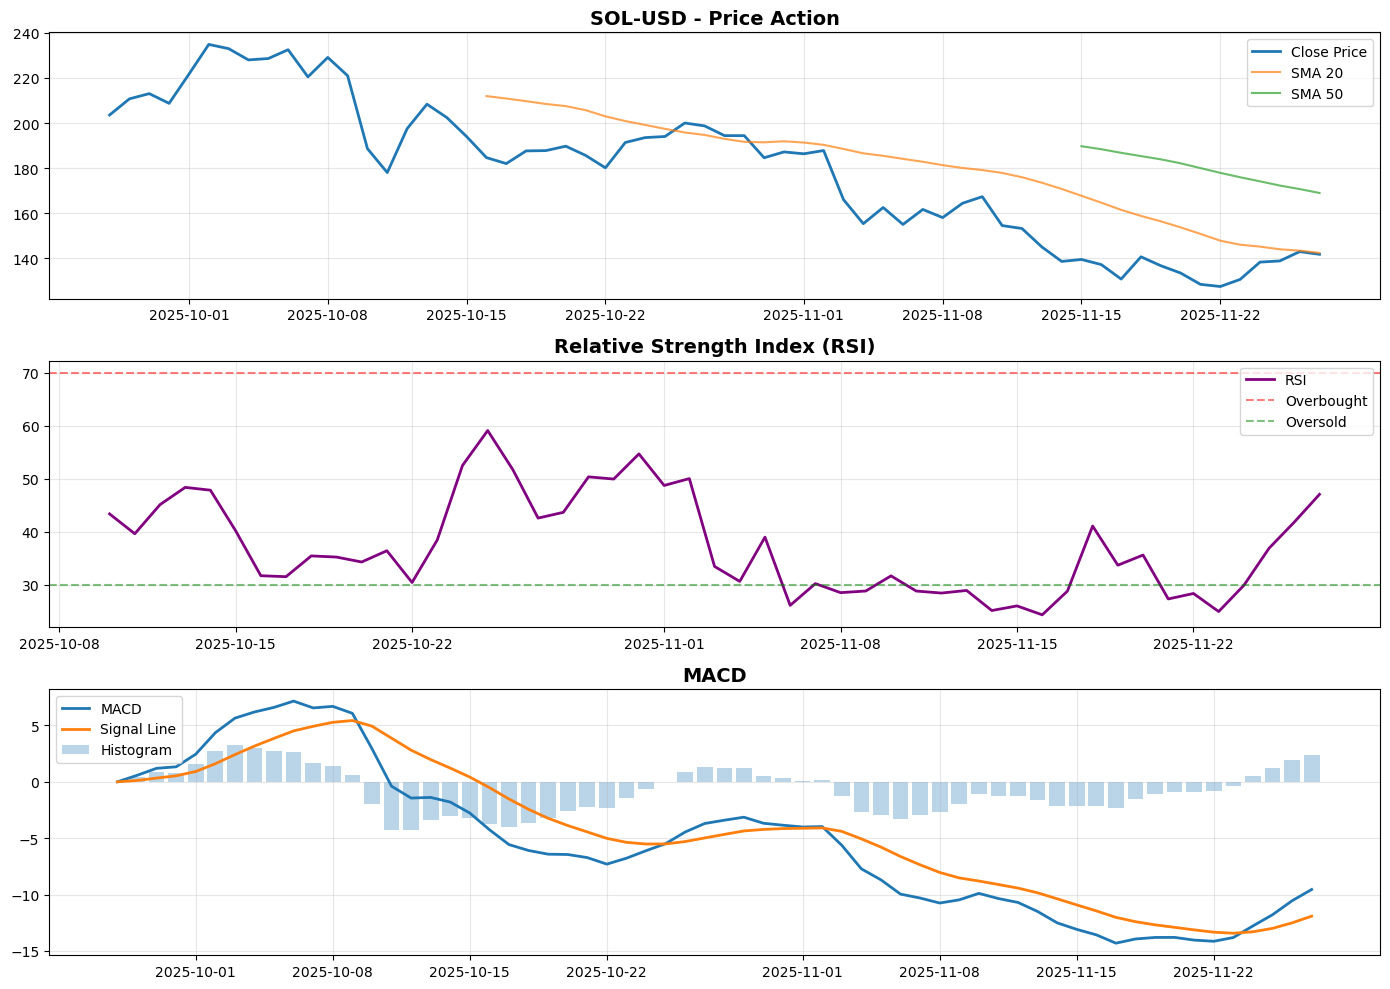

In [11]:
# Visualize BTC analysis
symbol = 'SOL-USD'
df = cryptowhiz.data_module.fetch_price_data(symbol, period='2mo')
df = cryptowhiz.ta_agent.calculate_indicators(df)
plot_analysis(symbol, df, cryptowhiz.ta_agent)